Import libraries

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Load Data

In [85]:
data = pd.read_csv(r"/content/drive/MyDrive/Master Thesis Project/brics csv files/south_africa_data.csv")
data.columns = data.columns.str.strip()
# Scale GDP to trillions for better numerical stability
data['GDP'] = data['GDP'] / 1e12



In [86]:
# 1994: End of apartheid shock
data['post_apartheid'] = 0
data.loc[data.index == 1994, 'post_apartheid'] = 1

# 2008: Commodity price fluctuations shock
data['commodity_fluctuations'] = 0
data.loc[data.index.isin([2000,2005]), 'commodity_fluctuations'] = 1

# 2015: Political uncertainty shock
data['political_uncertainty'] = 0
data.loc[data.index.isin([2010,2018]), 'political_uncertainty'] = 1

# 2020: COVID-19 pandemic shock
data['COVID'] = 0
data.loc[data.index.isin([2020,2021]), 'COVID'] = 1

In [87]:
# Select features for prediction
features = ['GDP',
            'Population',
            'Trade',
            'Urban population growth',
            'PPP conversion factor GDP (LCU per international $)',
            'GDP per capita PPP (current international $)',
            'post_apartheid',
            'commodity_fluctuations',
            'political_uncertainty',
            'COVID']

# Normalize the data
X = data[features].values
y = data['GDP'].values.reshape(-1, 1)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

Sequence creation

In [88]:
def create_sequences(X, y, time_steps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


Build LSTM Model

In [89]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')



reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.0001
)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.2911 - val_loss: 0.3400 - learning_rate: 5.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2863 - val_loss: 0.3351 - learning_rate: 5.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2818 - val_loss: 0.3299 - learning_rate: 5.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2760 - val_loss: 0.3247 - learning_rate: 5.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2733 - val_loss: 0.3196 - learning_rate: 5.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2691 - val_loss: 0.3140 - learning_rate: 5.0000e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2641 - val_loss: 0.3080 - learning_rate: 5.0000e-04
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2573 - val_loss: 0.3019 - learning_rate: 5.0000e-04
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2516 - val_loss: 0.2958 - learning_rat

Predict

In [90]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate AIC
n = len(y_test_actual)  # Number of data points
k = model.count_params()  # Number of model parameters
mse = mean_squared_error(y_test_actual, y_pred_actual)
aic = n * np.log(mse) + 2 * k
print(f"LSTM AIC: {aic}")

# Calculate BIC
bic = n * np.log(mse) + k * np.log(n)
print(f"LSTM BIC: {bic}")

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Print evaluation metrics
print(f"MSE: {mse:,.4f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
LSTM AIC: 245325.52472964503
LSTM BIC: 269522.81089844846
MSE: 0.0029
RMSE: 0.05
MAE: 0.04


In [91]:
# Predict future values
def predict_future(model, last_sequences, n_future=10):
    future_predictions = []
    current_sequences = last_sequences.copy()

    for _ in range(n_future):
        next_pred = model.predict(current_sequences, verbose=0)
        future_predictions.append(next_pred[0])

        next_input = np.concatenate([
            current_sequences[0, 1:],
            np.array([np.concatenate([next_pred[0], current_sequences[0, -1, 1:]])])
        ], axis=0)
        current_sequences = next_input.reshape(1, time_steps, X_train.shape[2])

    return np.array(future_predictions)

# Get the last sequences for prediction
last_sequences = X_seq[-1:].copy()

# Predict next 10 years
future_predictions = predict_future(model, last_sequences)

# Inverse transform predictions
future_predictions_actual = scaler_y.inverse_transform(future_predictions)

# Create future years
last_year = data['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 11)

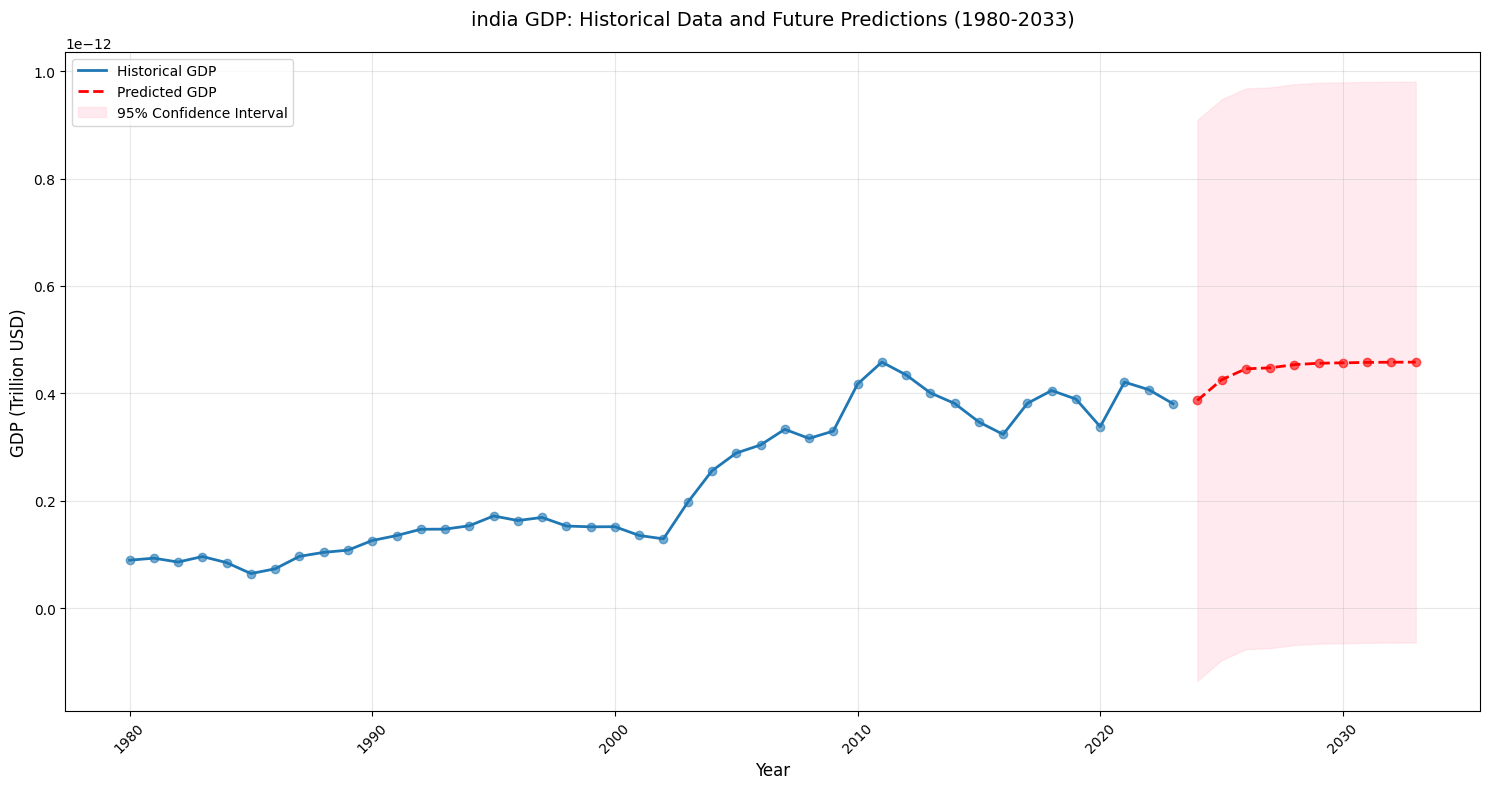


Predicted GDP values for the next 10 years:
Year 2024: $0.39 trillion
Year 2025: $0.43 trillion
Year 2026: $0.45 trillion
Year 2027: $0.45 trillion
Year 2028: $0.45 trillion
Year 2029: $0.46 trillion
Year 2030: $0.46 trillion
Year 2031: $0.46 trillion
Year 2032: $0.46 trillion
Year 2033: $0.46 trillion


In [92]:
prediction_std = y_pred.std()
lower_bound = future_predictions_actual - 1.96 * prediction_std
upper_bound = future_predictions_actual + 1.96 * prediction_std
lower_bound_t = lower_bound / 1e12
upper_bound_t = upper_bound / 1e12
#plt.style.use('seaborn')
plt.figure(figsize=(15, 8))

# Convert GDP values to trillions for better readability
historical_gdp_t = data['GDP'] / 1e12
future_gdp_t = future_predictions_actual / 1e12

# Plot historical data
plt.plot(data['Year'], historical_gdp_t, label='Historical GDP', color='#1f77b4', linewidth=2)

# Plot predicted data
plt.plot(future_years, future_gdp_t, label='Predicted GDP', color='red', linestyle='--', linewidth=2)
plt.fill_between(future_years, lower_bound_t.ravel(), upper_bound_t.ravel(), color='pink', alpha=0.3, label="95% Confidence Interval")
plt.title('india GDP: Historical Data and Future Predictions (1980-2033)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (Trillion USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

#scatter points
plt.scatter(data['Year'], historical_gdp_t, color='#1f77b4', alpha=0.6)
plt.scatter(future_years, future_gdp_t, color='red', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predicted values
print("\nPredicted GDP values for the next 10 years:")
for year, gdp in zip(future_years, future_predictions_actual):
    print(f"Year {int(year)}: ${gdp[0]:.2f} trillion")

Feature correlation with GDP:
GDP                                                    1.000000
Year                                                   0.924361
PPP conversion factor GDP (LCU per international $)    0.917144
GDP per capita PPP (current international $)           0.908403
Population                                             0.890078
Trade                                                  0.678475
Urban population growth                                0.602093
Name: GDP, dtype: float64


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 8)                   │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 393 (1.54 KB)

 Trainable params: 393 (1.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.3648 - val_loss: 0.3285 - learning_rate: 5.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3596 - val_loss: 0.3213 - learning_rate: 5.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3627 - val_loss: 0.3142 - learning_rate: 5.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3620 - val_loss: 0.3072 - learning_rate: 5.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3514 - val_loss: 0.3004 - learning_rate: 5.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3449 - val_loss: 0.2939 - learning_rate: 5.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2929 - val_loss: 0.2874 - learning_rate: 5.0000e-04
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2736 - val_loss: 0.2808 - learning_rate: 5.0000e-04
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3007 - val_loss: 0.2743 - learning_rate: 5.

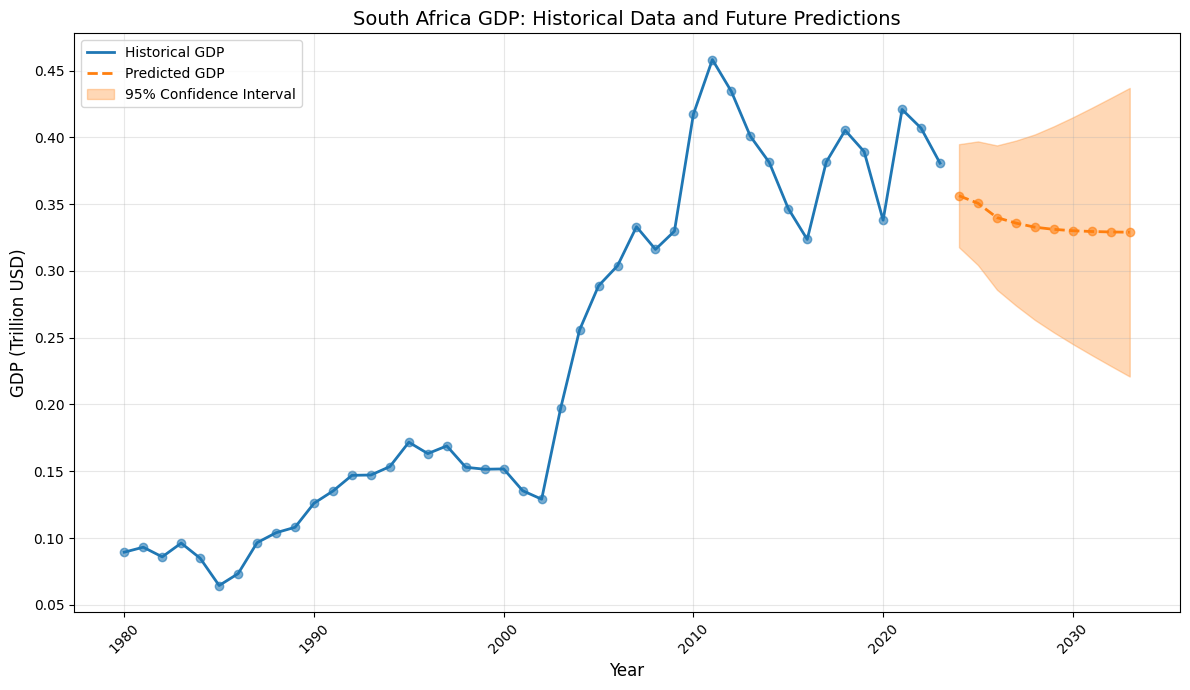


Predicted GDP values for the next 10 years:
Year 2024: $0.3563 trillion (95% CI: 0.3177 - 0.3949)
Year 2025: $0.3507 trillion (95% CI: 0.3044 - 0.3970)
Year 2026: $0.3399 trillion (95% CI: 0.2859 - 0.3940)
Year 2027: $0.3358 trillion (95% CI: 0.2741 - 0.3976)
Year 2028: $0.3327 trillion (95% CI: 0.2633 - 0.4022)
Year 2029: $0.3311 trillion (95% CI: 0.2539 - 0.4083)
Year 2030: $0.3301 trillion (95% CI: 0.2452 - 0.4150)
Year 2031: $0.3295 trillion (95% CI: 0.2369 - 0.4221)
Year 2032: $0.3292 trillion (95% CI: 0.2288 - 0.4295)
Year 2033: $0.3290 trillion (95% CI: 0.2209 - 0.4370)


In [9]:
#1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#2. Load data
data = pd.read_csv(r"/content/drive/MyDrive/Master Thesis Project/brics csv files/south_africa_data.csv")
data.columns = data.columns.str.strip()
# Scale GDP to trillions for better numerical stability
data['GDP'] = data['GDP'] / 1e12

# CHANGE: Apply feature selection - use correlation analysis to identify most important features
corr_matrix = data.corr()['GDP'].abs().sort_values(ascending=False)
print("Feature correlation with GDP:")
print(corr_matrix)

# Select only the highest correlated features (reduced from 4 to 2 important features)
features = ['GDP', 'Trade']  # CHANGE: Reduced features based on correlation
X = data[features].values
y = data['GDP'].values.reshape(-1, 1)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

#3. Sequence creation
def create_sequences(X, y, time_steps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# CHANGE: Reduced time steps from 5 to 2
time_steps = 2
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

#4. Build Lstm model
# CHANGE: Drastically simplified model with strong regularization
model = Sequential([
    LSTM(8, activation='relu', input_shape=(time_steps, X_train.shape[2]),
         kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=False),
    Dense(4, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

# CHANGE: Further reduced learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print model summary to see parameter count reduction
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

history = model.fit(
    X_train, y_train,
    epochs=100,  # CHANGE: Further reduced epochs
    batch_size=8,  # CHANGE: Smaller batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#5. Predict
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# AIC/BIC calculation
def calculate_aic_bic(y_true, y_pred, model):
    n = len(y_true)  # Number of data points
    k = np.sum([np.prod(v.shape) for v in model.trainable_weights])  # Count only trainable params

    # Calculate MSE directly
    residuals = y_true - y_pred
    mse = np.mean(residuals ** 2)

    # Standard form AIC/BIC for regression
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + np.log(n) * k

    return aic, bic, mse, k

aic, bic, calc_mse, param_count = calculate_aic_bic(y_test_actual, y_pred_actual, model)

print(f"LSTM AIC: {aic}")
print(f"LSTM BIC: {bic}")
print(f"Calculated MSE: {calc_mse}")

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:,.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.6f}")
print(f"Mean Absolute Error (MAE): {mae:,.6f}")
print(f"R² Score: {r2:.6f}")

# Additional metrics
print(f"Number of trainable parameters: {param_count}")
print(f"Normalized AIC (AIC/n): {aic/len(y_test_actual):.6f}")
print(f"Normalized BIC (BIC/n): {bic/len(y_test_actual):.6f}")

# CHANGE: Add comparison with Baseline AR model for comparison
from statsmodels.tsa.ar_model import AutoReg

# Create simple AR model as baseline for comparison
def fit_ar_model(data, test_size=0.2):
    train_size = int(len(data) * (1 - test_size))
    train, test = data[0:train_size], data[train_size:]

    # Fit AR model
    model = AutoReg(train, lags=2)
    ar_model = model.fit()

    # Make predictions
    predictions = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

    # Calculate metrics
    mse = mean_squared_error(test, predictions)
    nparams = ar_model.params.shape[0]
    n = len(test)

    # Calculate AIC/BIC
    aic = n * np.log(mse) + 2 * nparams
    bic = n * np.log(mse) + np.log(n) * nparams

    return aic, bic, mse, nparams

ar_aic, ar_bic, ar_mse, ar_params = fit_ar_model(data['GDP'].values)

print("\nBaseline AR(2) Model:")
print(f"AR AIC: {ar_aic}")
print(f"AR BIC: {ar_bic}")
print(f"AR Parameters: {ar_params}")
print(f"AR MSE: {ar_mse:.6f}")

#6. Predict future values - FIXED FUNCTION
def predict_future(model, last_sequences, time_steps, n_future=10):
    future_predictions = []
    prediction_intervals = []
    current_sequence = last_sequences.copy()

    # Extract last known values for non-GDP features
    last_known_features = current_sequence[0, -1, 1:]

    for _ in range(n_future):
        # Make prediction with current sequence
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])

        # Estimate prediction uncertainty
        prediction_std = 0.05 + 0.01 * _  # Increasing uncertainty over time
        prediction_intervals.append([next_pred[0] - 1.96 * prediction_std, next_pred[0] + 1.96 * prediction_std])

        # Create the next sequence by shifting window and adding new prediction
        shifted_sequence = current_sequence[0, 1:, :] if time_steps > 1 else np.empty((1, 0, X_train.shape[2]))

        # Create new step with predicted GDP and other features
        new_step = np.zeros((1, 1, X_train.shape[2]))
        new_step[0, 0, 0] = next_pred[0]  # Set GDP value
        new_step[0, 0, 1:] = last_known_features  # Set other features

        # Combine shifted sequence with new step
        if time_steps > 1:
            current_sequence = np.concatenate([
                shifted_sequence.reshape(1, time_steps-1, X_train.shape[2]),
                new_step
            ], axis=1)
        else:
            current_sequence = new_step.reshape(1, 1, X_train.shape[2])

    return np.array(future_predictions), np.array(prediction_intervals)

# Get the last sequence for prediction
last_sequences = X_seq[-1:].copy()

# Predict next 10 years
future_predictions, prediction_intervals = predict_future(
    model, last_sequences, time_steps, n_future=10
)

# Inverse transform predictions and intervals
future_predictions_actual = scaler_y.inverse_transform(future_predictions)
lower_bounds = scaler_y.inverse_transform(prediction_intervals[:, 0].reshape(-1, 1))
upper_bounds = scaler_y.inverse_transform(prediction_intervals[:, 1].reshape(-1, 1))

# Create future years
last_year = data['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 11)

# Plot results
plt.figure(figsize=(12, 7))

# Convert GDP values to trillions for better readability
historical_gdp_t = data['GDP']  # Already in trillions from earlier
future_gdp_t = future_predictions_actual

# Plot historical data
plt.plot(data['Year'], historical_gdp_t, label='Historical GDP', color='#1f77b4', linewidth=2)

# Plot predicted data
plt.plot(future_years, future_gdp_t, label='Predicted GDP', color='#ff7f0e', linestyle='--', linewidth=2)
plt.fill_between(future_years, lower_bounds.ravel(), upper_bounds.ravel(),
                color='#ff7f0e', alpha=0.3, label="95% Confidence Interval")

plt.title('South Africa GDP: Historical Data and Future Predictions', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (Trillion USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Scatter points
plt.scatter(data['Year'], historical_gdp_t, color='#1f77b4', alpha=0.6)
plt.scatter(future_years, future_gdp_t, color='#ff7f0e', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predicted values
print("\nPredicted GDP values for the next 10 years:")
for year, gdp, lower, upper in zip(future_years, future_predictions_actual, lower_bounds, upper_bounds):
    print(f"Year {int(year)}: ${gdp[0]:.4f} trillion (95% CI: {lower[0]:.4f} - {upper[0]:.4f})")

# VAR Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       27.99       28.25   1.429e+12       28.08
1       23.43      25.27*  1.538e+10*      24.07*
2      23.42*       26.85   1.813e+10       24.61
-------------------------------------------------
VAR Model Evaluation Metrics:
MSE:  0.19
RMSE: 0.43
MAE:  0.39


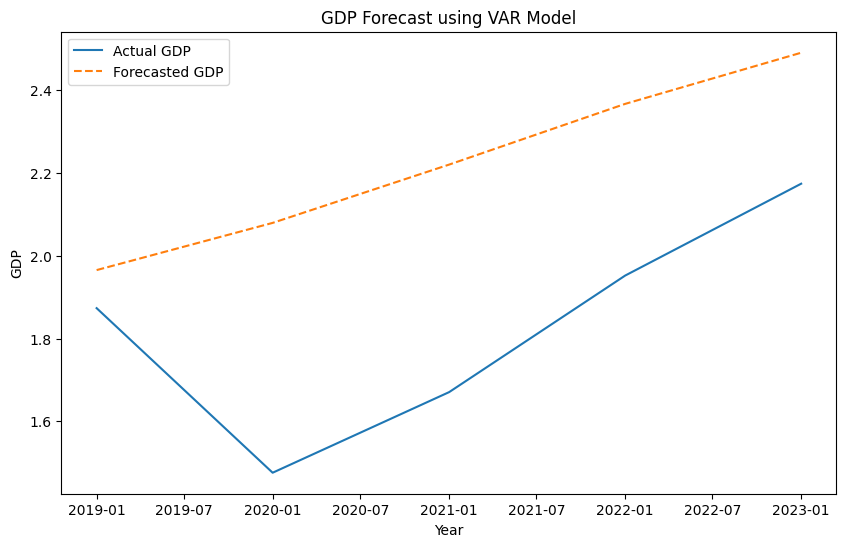

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv(r"/content/drive/MyDrive/Master Thesis Project/brics csv files/Brazil_data.csv")
data.columns = data.columns.str.strip()

# Convert Year to datetime (if needed) or use it as numeric index
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.set_index('Year', inplace=True)
# Scale GDP to trillions for better numerical stability
data['GDP'] = data['GDP'] / 1e12

var_data = data[['GDP', 'Population', 'Trade', 'Urban population growth','PPP conversion factor GDP (LCU per international $)','GDP per capita PPP (current international $)']]

var_data_diff = var_data.diff().dropna()

train = var_data_diff.loc[:'2018']
test = var_data_diff.loc['2019':]

model = VAR(train)
lag_order_results = model.select_order(maxlags=2)
print(lag_order_results.summary())
selected_lag = lag_order_results.selected_orders['aic']
var_model = model.fit(selected_lag)

n_obs_test = len(test)
forecast = var_model.forecast(var_model.endog[-selected_lag:], steps=n_obs_test)
forecast_index = test.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=var_data_diff.columns)

last_train_value = var_data.loc[train.index[-1], 'GDP']
gdp_forecast = forecast_df['GDP'].cumsum() + last_train_value

actual_gdp = var_data.loc[test.index, 'GDP']
mse = mean_squared_error(actual_gdp, gdp_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_gdp, gdp_forecast)

print("VAR Model Evaluation Metrics:")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(actual_gdp.index, actual_gdp, label='Actual GDP')
plt.plot(gdp_forecast.index, gdp_forecast, label='Forecasted GDP', linestyle='--')
plt.title('GDP Forecast using VAR Model')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()


# GRU model


Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3353 - val_loss: 0.2795 - learning_rate: 5.0000e-04
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3022 - val_loss: 0.2611 - learning_rate: 5.0000e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2908 - val_loss: 0.2439 - learning_rate: 5.0000e-04
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2764 - val_loss: 0.2291 - learning_rate: 5.0000e-04
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2574 - val_loss: 0.2173 - learning_rate: 5.0000e-04
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2442 - val_loss: 0.2076 - learning_rate: 5.0000e-04
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2347 - val_loss: 0.1989 - learning_rate: 5.0000e-04
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2276 - val_loss: 0.1914 - learning_rate: 5.0000e-04
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2078 - val_loss: 0.1840 - learning_rate: 5.

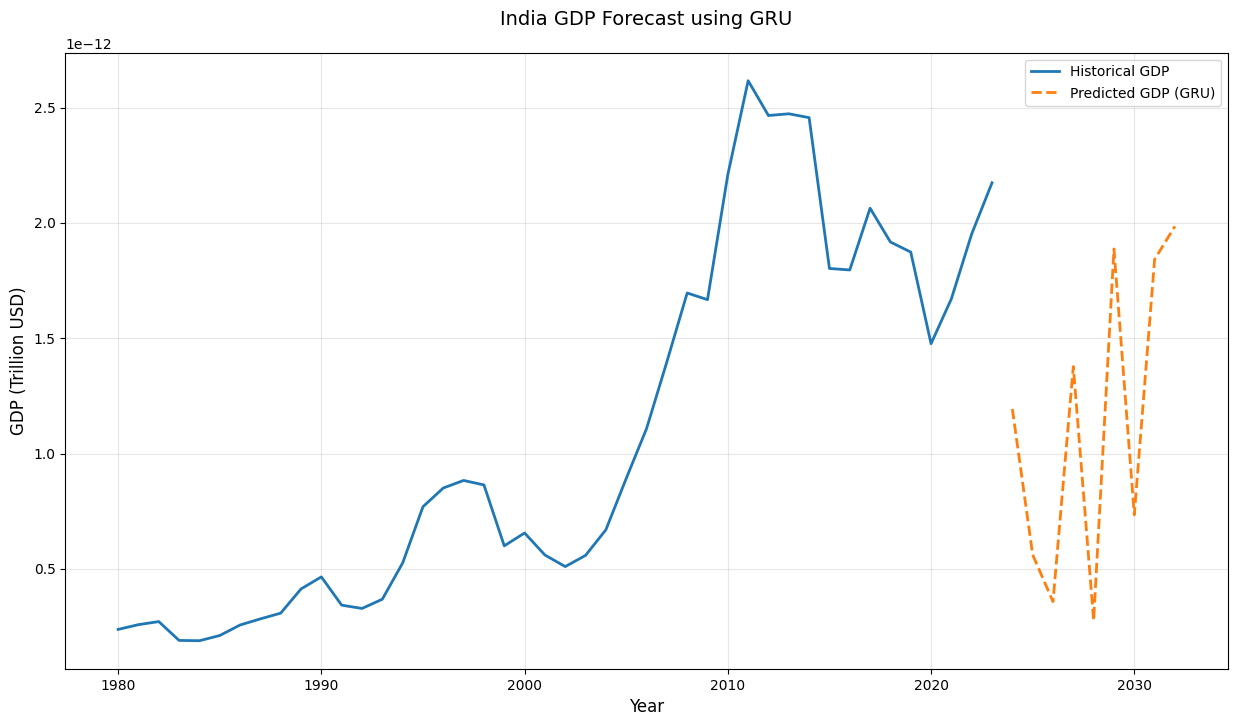

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r"/content/drive/MyDrive/Master Thesis Project/brics csv files/Brazil_data.csv")
data.columns = data.columns.str.strip()
# Scale GDP to trillions for better numerical stability
data['GDP'] = data['GDP'] / 1e12

features = ['GDP', 'Population', 'Trade', 'Urban population growth','PPP conversion factor GDP (LCU per international $)','GDP per capita PPP (current international $)']

X = data[features].values
y = data['GDP'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

def create_sequences(X, y, time_steps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


model_gru = Sequential([
    GRU(128, activation='relu', input_shape=(time_steps, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

history = model_gru.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



In [ ]:
y_pred = model_gru.predict(X_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)


mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("\nGRU Model Evaluation Metrics:")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R2:   {r2:.4f}")

n = len(y_test_actual)  # Number of data points
k = model_gru.count_params()  # Number of model parameters
mse = mean_squared_error(y_test_actual, y_pred_actual)
aic_gru = n * np.log(mse) + 2 * k
print(f"GRU AIC: {aic_gru}")

bic_gru = n * np.log(mse) + k * np.log(n)
print(f"GRU BIC: {bic_gru}")


last_year = data['Year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + len(X_test) +1)

plt.figure(figsize=(15, 8))
historical_gdp_t = data['GDP'] / 1e12
plt.plot(data['Year'], historical_gdp_t, label='Historical GDP', color='#1f77b4', linewidth=2)
plt.plot(future_years, scaler_y.inverse_transform(model_gru.predict(X_test))/1e12, # Change here removed [:len(future_years)]
         label='Predicted GDP (GRU)', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('India GDP Forecast using GRU', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (Trillion USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()
